## Using facebook prophet, I'm interested in trying to predict the volume of different citations over time.

my inspiration for this https://pbpython.com/prophet-overview.html

### Import and Prep data

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\mrkjh\Miniconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [15]:
citations = pd.read_csv('https://raw.githubusercontent.com/mrkjhsn/Scottsdale_Datasets/master/citations.csv', 
                        index_col='Citation #',
                       low_memory=False)

In [25]:
citations.shape

(60859, 21)

In [4]:
citations.head()

,Arizona Statute Code,Beat,Charge Description,Citation Date,Citation Time,Citation Type Code,Citation Type Description,Cited Person,Cited Person Age,Cited Person Ethnicity,...,Cited Person Sex,City,District,Officer Badge #,State,Street,Street Number,Zip,Zone,tcmainid
Citation #,,,,,,,,,,,,,,,,,,,,,
2074492,97XX,12.0,Amended Charge,12/20/2018,2222,CV,Civil Traffic,"Way, Dennis",51,U,...,M,Scottsdale,D3,1476,AZ,E Sahuaro DR / N Scottsdale Rd,xxx,NaN,3003.0,641301
8093305,28-701A,10.0,Speed Greater Than R&P or Posted,12/20/2018,844,CV,Civil Traffic,"Grady, Scott",61,U,...,M,Scottsdale,D3,780,AZ,N Scottsdale Rd,8xxx,NaN,2601.0,641302
2076259,28-4135C,3.0,No Proof of Insurance,12/18/2018,2147,CV,Civil Traffic,"Dudgeon, Miranda",20,U,...,F,Scottsdale,D1,1509,AZ,E Osborn Rd / N Scottsdale Rd,xxx,NaN,706.0,641303
8093703,28-2532A,5.0,Expired/No Arizona Registration,12/21/2018,2116,CV,Civil Traffic,"Fox, William",34,U,...,M,Scottsdale,D2,826,AZ,E Chaparral Rd / N Hayden Rd,xxx,NaN,1106.0,641304
2053182,28-4135C,15.0,No Proof of Insurance,12/20/2018,2324,CV,Civil Traffic,"Rhoden, David",24,U,...,M,Scottsdale,D4,1440,AZ,E Frank Lloyd Wright Bl / N Hayden Rd,xxx,NaN,3604.0,641305


In [5]:
citations.loc[:,'Citation Date'] = pd.to_datetime(citations['Citation Date'])

In [6]:
citations['Citation Date'].min()

Timestamp('2017-09-23 00:00:00')

In [7]:
citations['Citation Date'].max()

Timestamp('2020-05-03 00:00:00')

In [8]:
# aggregate based on count per day
count_per_day = citations.groupby('Citation Date').size().reset_index()

In [9]:
# assign labels to colmns
# based on what Prophet requires
count_per_day.columns = ["ds", "y"]

In [10]:
count_per_day

,ds,y
0,2017-09-23,32
1,2017-09-24,75
2,2017-09-25,90
3,2017-09-26,80
4,2017-09-27,106
...,...,...
949,2020-04-29,9
950,2020-04-30,21
951,2020-05-01,9
952,2020-05-02,11


### Model using Prophet

In [11]:
m1 = Prophet()
m1.fit(count_per_day)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


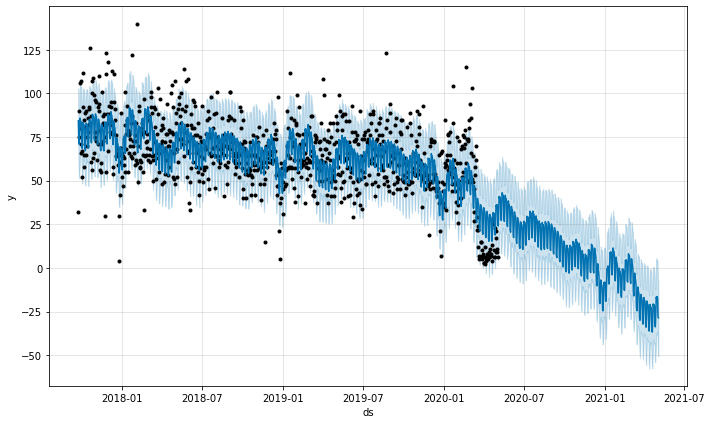

In [12]:
# predict 1 year into the future
future1 = m1.make_future_dataframe(periods=365)

# make forecast
forecast1 = m1.predict(future1)

# plot forecast
m1.plot(forecast1);

Clearly covid-19 has dramatically reduced citation counts, which is causing the model to predict a downward trend for the future.

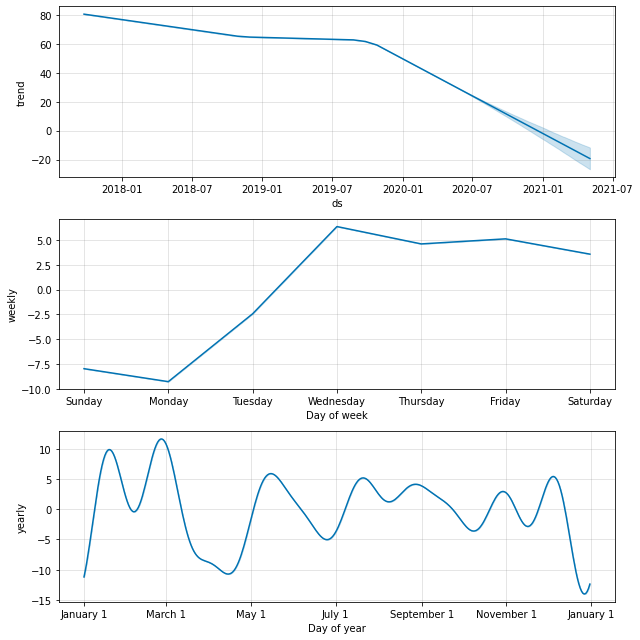

In [17]:
m1.plot_components(forecast1);

It's unclear to me why Wednesday has the most.

### Exclude dates in 2020 to avoid Covid-19 influence

In [56]:
citations[citations['Citation Date'] < '2020-01-01'].shape

(55780, 21)

In [57]:
# aggregate based on count per day
count_per_day = citations[citations['Citation Date'] < '2020-01-01'].groupby('Citation Date').size().reset_index()

In [58]:
# assign labels to colmns
# based on what Prophet requires
count_per_day.columns = ["ds", "y"]

In [59]:
count_per_day

,ds,y
0,2017-09-23,32
1,2017-09-24,75
2,2017-09-25,90
3,2017-09-26,80
4,2017-09-27,106
...,...,...
825,2019-12-27,66
826,2019-12-28,67
827,2019-12-29,49
828,2019-12-30,44


In [60]:
m1 = Prophet()
m1.fit(count_per_day)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


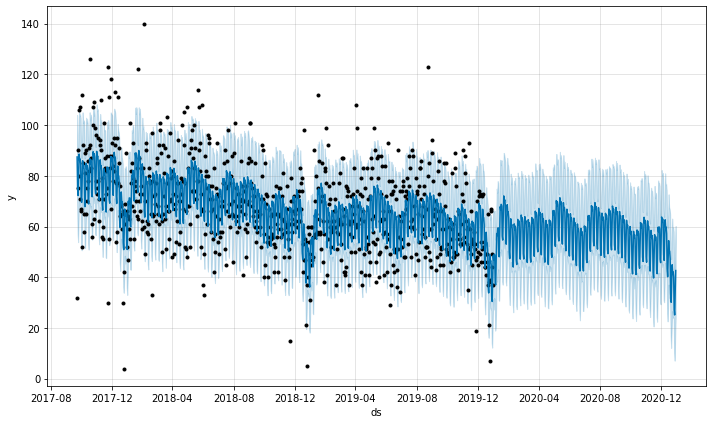

In [62]:
# predict 1 year into the future
future1 = m1.make_future_dataframe(periods=365)

# make forecast
forecast1 = m1.predict(future1)

# plot forecast
m1.plot(forecast1);

Clearly covid-19 has dramatically reduced citation counts, which is causing the model to predict a downward trend for the future.

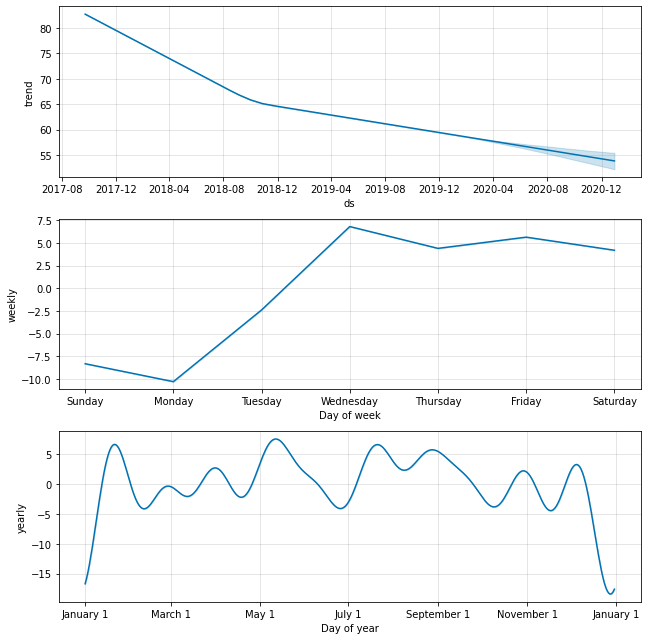

In [63]:
m1.plot_components(forecast1);

### Dig deeper into trends of specific citation types

In [30]:
# based on the week of the year
citations['Citation Date'].dt.weekofyear

Citation #
2074492    51
8093305    51
2076259    51
8093703    51
2053182    51
           ..
8097857    18
8097856    18
8097855    18
8100779    18
2101557    18
Name: Citation Date, Length: 60859, dtype: int64

In [64]:
# which citation type has the largest variance
# over the course of the year?

citations.groupby(["Charge Description", citations['Citation Date'] \
                   .dt.weekofyear]).size().unstack().var(axis=1) \
                    .sort_values(ascending=False).head(20)

Charge Description
Speed Greater Than R&P or Posted                   4739.108220
Lap and Shoulder Belts Required                     581.433333
Expired/No Arizona Registration                     442.956259
Failure to Control Speed to Avoid A Collision       305.596908
Suspended/Revoked D.L.                              234.694947
DUI-Impaired to Slightest Degree                    212.211161
Exceed 15mph In School Crossing                     209.409615
Parking to Obstruct Traffic                         182.285714
No Proof of Insurance                               174.245475
Loading or Unloading In Through Lane                144.114130
Drug Paraphernalia-Possess/Use                      137.461161
Fail to Obey Traffic Control Device                 136.013575
Fail to Stop at Stop Sign                           120.996606
Fail to Stop For Red Signal                          71.978884
Exceed Limit By More Than 20mph                      56.809955
Urinate/Defecate In Public          

In [44]:
citations.groupby(["Charge Description", citations['Citation Date'] \
                   .dt.weekofyear]).size().unstack().var(axis=1) \
                    .sort_values(ascending=False).head(10).index

Index(['Speed Greater Than R&P or Posted', 'Lap and Shoulder Belts Required',
       'Expired/No Arizona Registration',
       'Failure to Control Speed to Avoid A Collision',
       'Suspended/Revoked D.L.', 'DUI-Impaired to Slightest Degree',
       'Exceed 15mph In School Crossing', 'Parking to Obstruct Traffic',
       'No Proof of Insurance', 'Loading or Unloading In Through Lane'],
      dtype='object', name='Charge Description')

In [50]:
# subset based on the top 5
citations[citations['Charge Description'].isin(citations.groupby(["Charge Description", citations['Citation Date'] \
                   .dt.weekofyear]).size().unstack().var(axis=1) \
                    .sort_values(ascending=False).head(5).index)]

,Arizona Statute Code,Beat,Charge Description,Citation Date,Citation Time,Citation Type Code,Citation Type Description,Cited Person,Cited Person Age,Cited Person Ethnicity,...,Cited Person Sex,City,District,Officer Badge #,State,Street,Street Number,Zip,Zone,tcmainid
Citation #,,,,,,,,,,,,,,,,,,,,,
8093305,28-701A,10.0,Speed Greater Than R&P or Posted,2018-12-20,844,CV,Civil Traffic,"Grady, Scott",61,U,...,M,Scottsdale,D3,780,AZ,N Scottsdale Rd,8xxx,NaN,2601.0,641302
8093703,28-2532A,5.0,Expired/No Arizona Registration,2018-12-21,2116,CV,Civil Traffic,"Fox, William",34,U,...,M,Scottsdale,D2,826,AZ,E Chaparral Rd / N Hayden Rd,xxx,NaN,1106.0,641304
8093304,28-701A,10.0,Speed Greater Than R&P or Posted,2018-12-20,803,CV,Civil Traffic,"Meltzer, Travis",30,U,...,M,Scottsdale,D3,780,AZ,N Scottsdale Rd,8xxx,NaN,2601.0,641306
8092697,28-701A,18.0,Speed Greater Than R&P or Posted,2018-12-22,1609,CV,Civil Traffic,"Case, Felicia",49,U,...,F,Scottsdale,D4,1450,AZ,N Pima Rd,2xxx,NaN,3906.0,641307
8093306,28-701A,10.0,Speed Greater Than R&P or Posted,2018-12-20,859,CV,Civil Traffic,"Roholt, Michael",43,U,...,M,Scottsdale,D3,780,AZ,N Scottsdale Rd,8xxx,NaN,2601.0,641308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8097859,28-701A,19.0,Speed Greater Than R&P or Posted,2020-05-02,1424,CV,Civil Traffic,"Seguin, JOshua",31,U,...,M,Scottsdale,D4,806,AZ,E Adobe DR / N Miller Rd,xxx,NaN,3901.0,689658
8097857,28-701A,17.0,Speed Greater Than R&P or Posted,2020-05-02,1008,CV,Civil Traffic,"Martinez, Evelyn",33,H,...,F,Scottsdale,D4,806,AZ,N 100th St,1xxx,NaN,3406.0,689661
8097856,28-701A,13.0,Speed Greater Than R&P or Posted,2020-05-02,644,CV,Civil Traffic,"Zayas, Bozena",39,U,...,F,Scottsdale,D3,806,AZ,E Shea Bl / E Via Linda,xxx,NaN,2911.0,689662


### Focus on only one specific citation type 'Exceed 15mph In School Crossing'

In [71]:
# aggregate based on count per day
count_per_day = citations[(citations['Charge Description'] == 'Exceed 15mph In School Crossing') &
         (citations['Citation Date'] < '2020-01-01')].groupby('Citation Date').size().reset_index()

In [72]:
# assign labels to colmns
# based on what Prophet requires
count_per_day.columns = ["ds", "y"]

In [73]:
count_per_day

,ds,y
0,2017-09-25,5
1,2017-09-26,2
2,2017-09-27,3
3,2017-09-28,1
4,2017-10-02,2
...,...,...
295,2019-12-05,5
296,2019-12-10,3
297,2019-12-11,2
298,2019-12-13,2


In [74]:
m1 = Prophet()
m1.fit(count_per_day)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


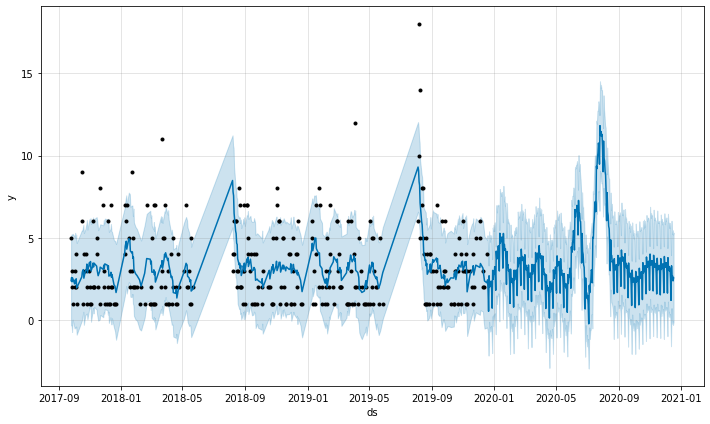

In [75]:
# predict 1 year into the future
future1 = m1.make_future_dataframe(periods=365)

# make forecast
forecast1 = m1.predict(future1)

# plot forecast
m1.plot(forecast1);

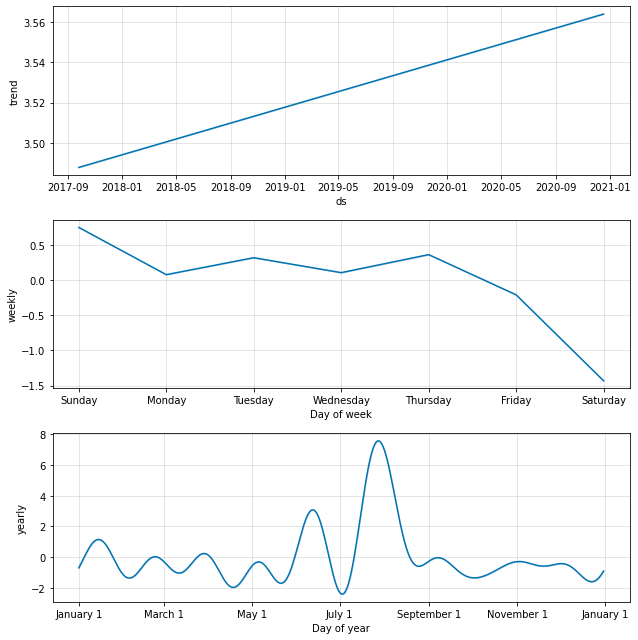

In [76]:
m1.plot_components(forecast1);

When school starts up each year is the largest peak of this citation type.

### Focus on only one specific citation type 'Failure to Control Speed to Avoid A Collision'

In [89]:
# aggregate based on count per day
count_per_day = citations[(citations['Charge Description'] == 'Failure to Control Speed to Avoid A Collision') &
         (citations['Citation Date'] < '2020-01-01')].groupby('Citation Date').size().reset_index()

In [90]:
# assign labels to colmns
# based on what Prophet requires
count_per_day.columns = ["ds", "y"]

In [91]:
count_per_day

,ds,y
0,2017-09-25,5
1,2017-09-26,4
2,2017-09-27,10
3,2017-09-28,7
4,2017-09-29,2
...,...,...
750,2019-12-24,3
751,2019-12-26,2
752,2019-12-27,5
753,2019-12-28,2


In [92]:
m1 = Prophet(weekly_seasonality=True)
m1.fit(count_per_day)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


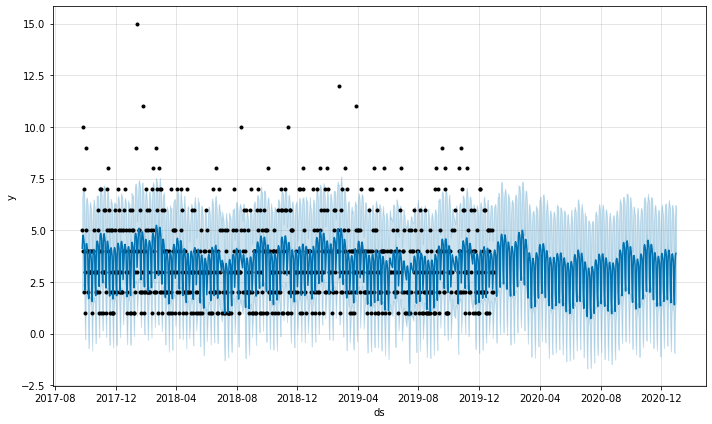

In [93]:
# predict 1 year into the future
future1 = m1.make_future_dataframe(periods=365)

# make forecast
forecast1 = m1.predict(future1)

# plot forecast
m1.plot(forecast1);

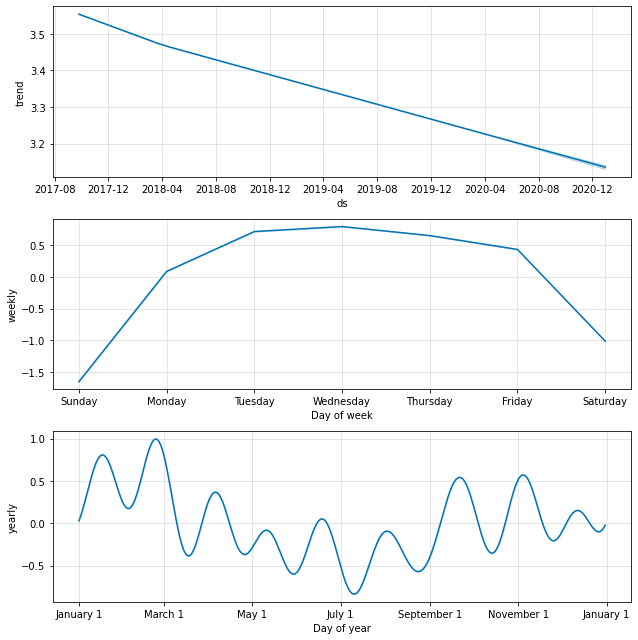

In [94]:
m1.plot_components(forecast1);

### Focus on only one specific citation type 'Liquor-Under 21 Any Liquor In Body'

In [83]:
# aggregate based on count per day
count_per_day = citations[(citations['Charge Description'] == 'Liquor-Under 21 Any Liquor In Body') &
         (citations['Citation Date'] < '2020-01-01')].groupby('Citation Date').size().reset_index()

In [84]:
# assign labels to colmns
# based on what Prophet requires
count_per_day.columns = ["ds", "y"]

In [85]:
count_per_day

,ds,y
0,2017-10-11,1
1,2017-10-15,2
2,2017-11-11,4
3,2017-12-03,2
4,2017-12-15,1
...,...,...
63,2019-11-09,1
64,2019-11-12,1
65,2019-12-01,1
66,2019-12-06,4


In [86]:
m1 = Prophet()
m1.fit(count_per_day)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


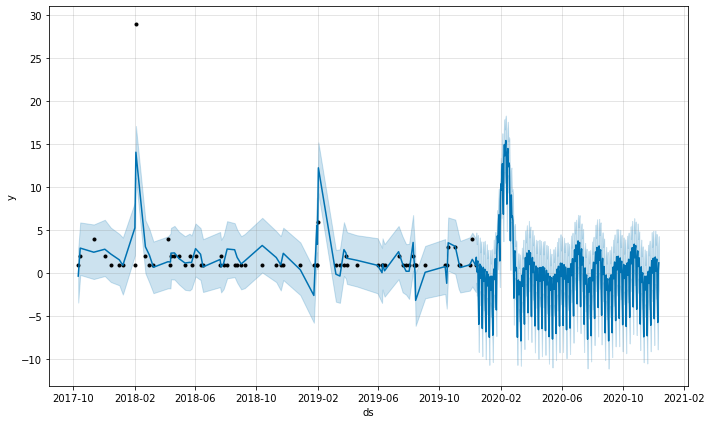

In [87]:
# predict 1 year into the future
future1 = m1.make_future_dataframe(periods=365)

# make forecast
forecast1 = m1.predict(future1)

# plot forecast
m1.plot(forecast1);

There seems to be a strong peak during the WM Open each February.

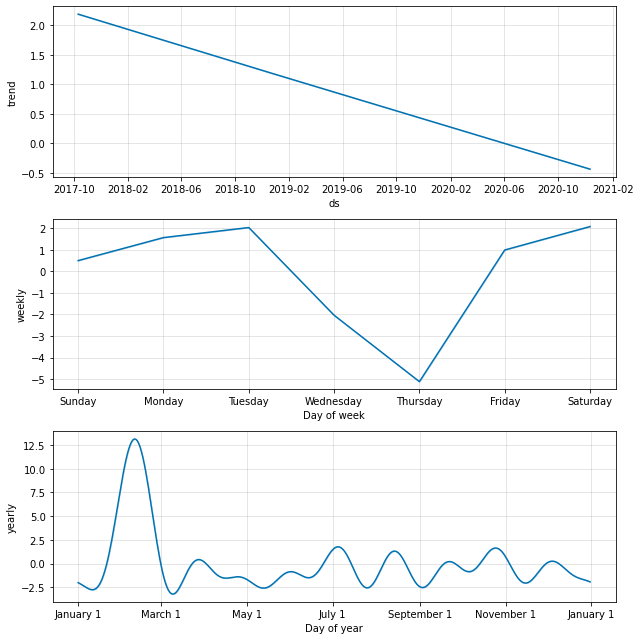

In [88]:
m1.plot_components(forecast1);